# Winning Jeopardy
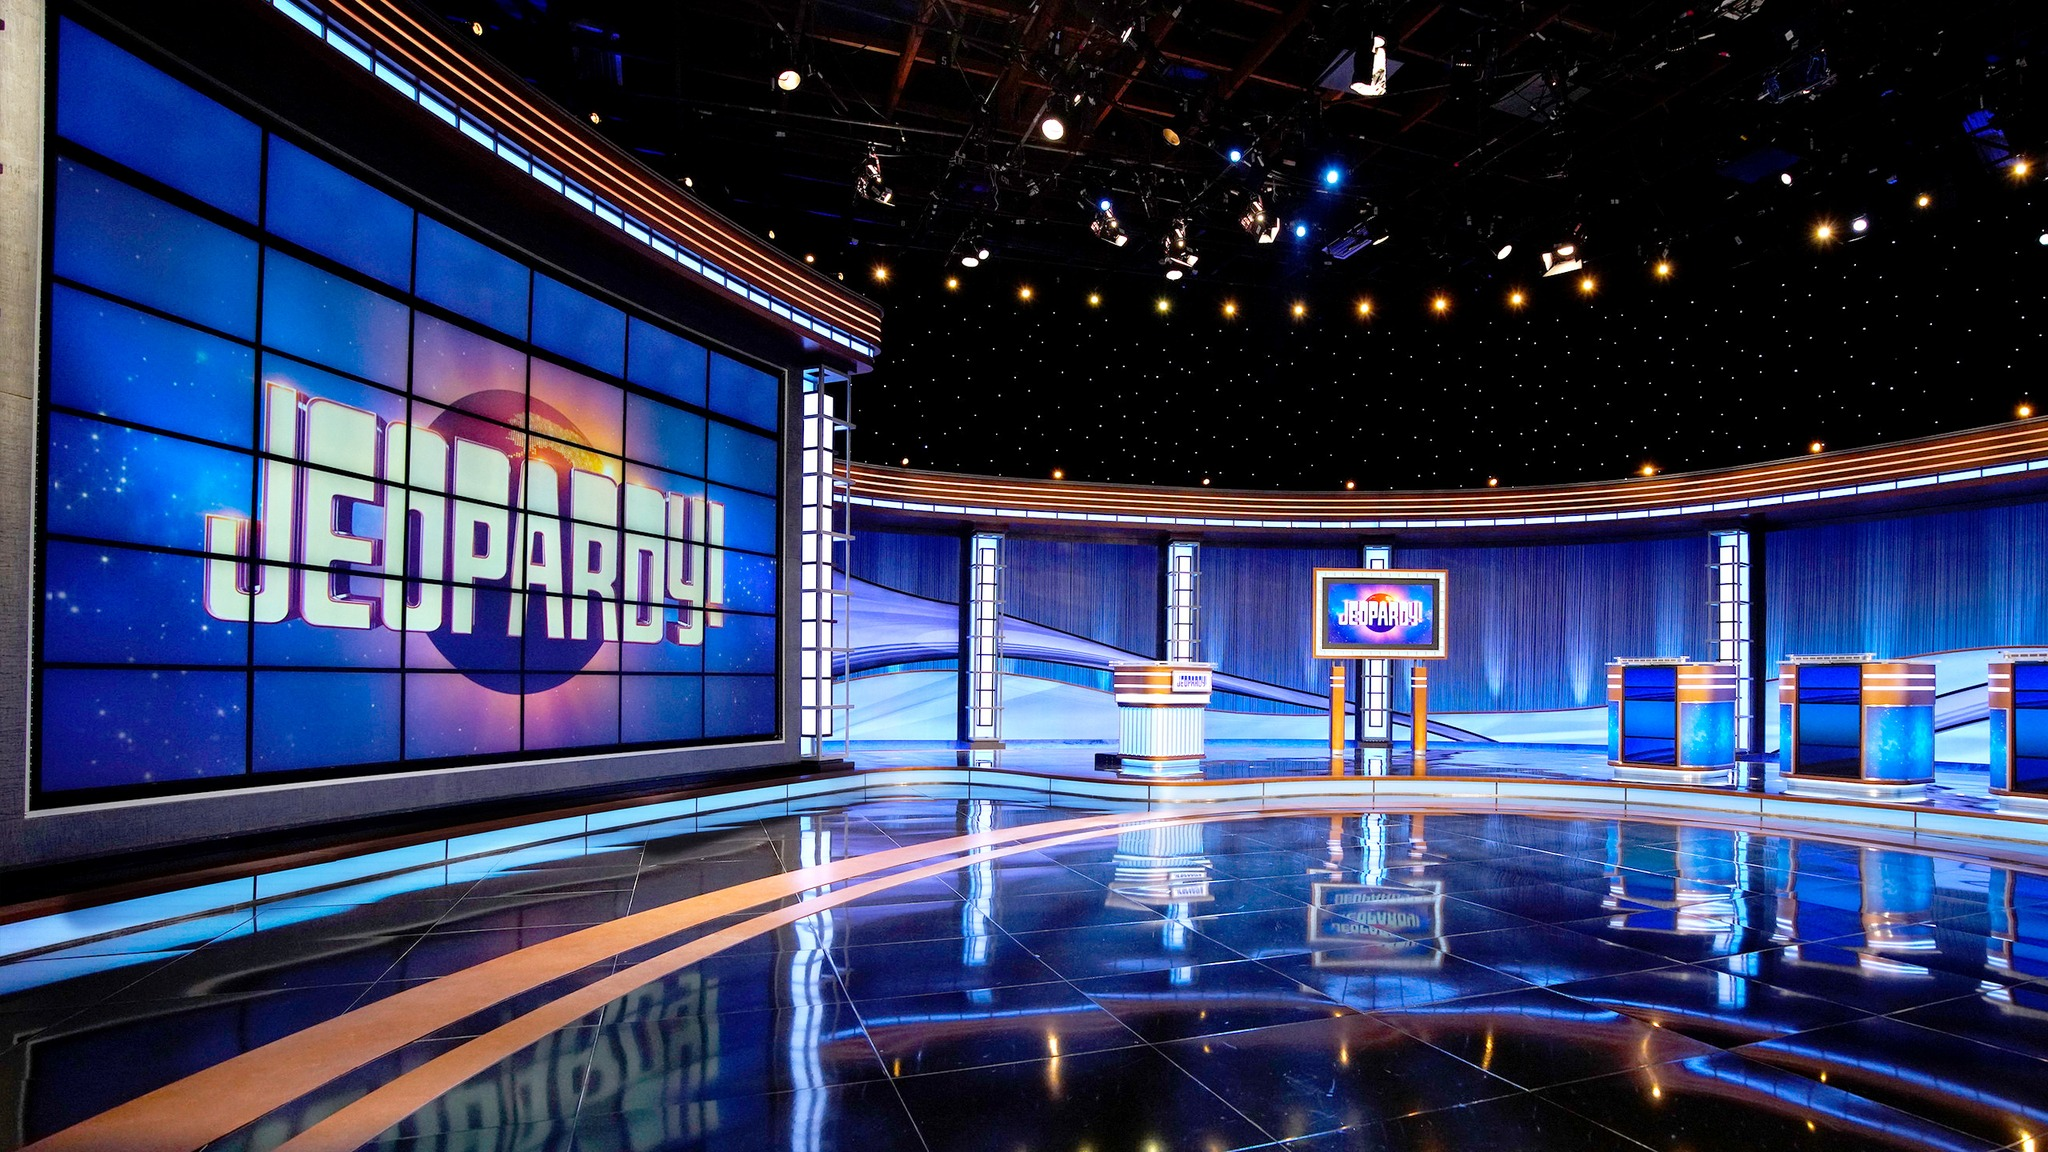
In this project, we will work with a dataset of Jeopardy questions to figure out some patterns in the questions that could help us to win.

Jeopardy is a popular TV show in the US where participants answer questions to win money. It's been running for many years, and is a major force in popular culture. This is an official __[website](https://www.jeopardy.com/)__.

The dataset is named jeopardy.csv, and contains over 200,000 rows from the beginning of a full dataset of Jeopardy questions, it can be downloaded __[here](https://www.reddit.com/r/datasets/comments/1uyd0t/200000_jeopardy_questions_in_a_json_file/)__.


## 1. Normalizing data

In [1]:
# Reading the dataset
import pandas as pd
import csv

jeopardy = pd.read_csv('JEOPARDY_CSV.csv', keep_default_na=False)
# Some questions contain ‘null’, ‘None’, etc as answers, thus preventing our dataset to recognize them as NaN values 

jeopardy.shape

(216930, 7)

In [2]:
jeopardy.head()

,Show Number,Air Date,Round,Category,Value,Question,Answer
0,4680,2004-12-31,Jeopardy!,HISTORY,$200,"For the last 8 years of his life, Galileo was ...",Copernicus
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,$200,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,$200,The city of Yuma in this state has a record av...,Arizona
3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,$200,"In 1963, live on ""The Art Linkletter Show"", th...",McDonald's
4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,$200,"Signer of the Dec. of Indep., framer of the Co...",John Adams


In [3]:
jeopardy.columns

Index(['Show Number', ' Air Date', ' Round', ' Category', ' Value',
       ' Question', ' Answer'],
      dtype='object')

In [4]:
# Removing the spaces from the column names 
jeopardy.columns = ['Show Number', 'Air Date', 'Round', 'Category', 'Value', 'Question', 'Answer']

In [5]:
# Removing all punctuation, the sequences of one or more whitespace characters  and converting to lowercase.
jeopardy['clean_question'] = jeopardy['Question'].str.replace('\W',' ').str.lower()
jeopardy['clean_answer'] = jeopardy['Answer'].str.replace('\W', ' ').str.lower()


In [6]:
# Removing $ from the value column, replacing None values with 0 and converting to integers
jeopardy['clean_value'] = jeopardy['Value'].str.replace('\W', '').str.replace('None', '0').astype(int)


In [7]:
# Converting to a datetime column
jeopardy['Air Date'] = pd.to_datetime(jeopardy['Air Date'])

In [8]:
# Verifying our results
jeopardy.dtypes

Show Number                int64
Air Date          datetime64[ns]
Round                     object
Category                  object
Value                     object
Question                  object
Answer                    object
clean_question            object
clean_answer              object
clean_value                int32
dtype: object

## 2. Increasing chances of winning
Now we will attempt to find patterns in the questions that could potentially help us win.

### Answers in questions

First, we should check if words in answers also occurred in questions. If yes, how often do they match.

In [9]:
def matching_qa (row):
    split_answer = row['clean_answer'].split()
    split_question = row['clean_question'].split()
    match_count = 0
    
    # The word 'the' doesn't have any meaningful use in finding the answer
    if 'the' in split_answer:
        split_answer.remove('the')
    
    # This prevents a division by zero error 
    if len(split_answer) == 0: 
        return 0
    
    for i in split_answer:
        if i in split_question:
            match_count += 1
    return match_count/len(split_answer)

In [10]:
# Counting how many times terms in clean_answer occur in clean_question
jeopardy['answer_in_question'] = jeopardy.apply(matching_qa, axis =1)

In [11]:
jeopardy['answer_in_question'].mean()

0.0614146067204666

Approximately in 6% cases the answers is mentioned in the question. This is relatively insignificant number, hence we cannot rely on this approach to increase our chances of winning. 

### Repeated questions

Now we are going to investigate how often new questions are repeats of older ones. The idea behind is to check if the words in the questions have been used previously.

In [12]:
# Sorting data in order of ascending air date
jeopardy = jeopardy.sort_values('Air Date')

In [13]:
question_overlap = []
terms_used = set()

for i, row in jeopardy.iterrows():
    split_question = row['clean_question'].split()
    split_question = [q for q in split_question if len(q) > 5] 
    # Removing any word shorter than 6 characters, to filter out words like ‘the’, ‘than’, etc. 
    
    match_count = 0
    # If each word occurs in terms_used set, increment a counter
    for word in split_question:
        if word in terms_used:
            match_count += 1  
    for word in split_question:    
        terms_used.add(word)   
    if len(split_question) > 0:
        match_count /= len(split_question)
    question_overlap.append(match_count)

jeopardy['question_overlap'] = question_overlap
mean = round(jeopardy['question_overlap'].mean()*100)
print(f'{mean}% of meaningful words overlap in questions.')

90% of meaningful words overlap in questions.


We observe a significant overlap between meaningful words of all the questions in the dataset. Although we ignore all words less than 6 characters long (in order to avoid auxiliary words such as than, then, these, ect), there is a strong possibility of recycling the questions. This can be investigated further should needed.  

### Low Value vs High Value Questions

Should we decide to maximise our winning gains, we can concentrate on questions with higher value rather than lower.  We can find out which terms correspond to high-value questions using a chi-squared test. 

In [14]:
# Narrowing down the questions into two categories: > $800 and <$800
def low_high_value (row):
    value = 0
    if row['clean_value'] > 800:
        value += 1
    return value

jeopardy['high_value'] = jeopardy.apply(low_high_value, axis =1)

In [15]:
# Finding the number of low and high value questions the word occurs in
def count_function(word):
    low_count = 0
    high_count = 0
    for i, row in jeopardy.iterrows():
        split_question = row['clean_question'].split()
        if word in split_question:
            if row['high_value'] == 1:
                high_count += 1
            else:
                low_count += 1
    return high_count, low_count

In [16]:
import random
terms_used_list = list(terms_used)

# Applying the chi squared values to all the words would take a very long time,
# so we should do it for a small random sample of 10 
comparison_terms = random.choices(terms_used_list, k =10)

# Applying function to our selection
observed_expected = []
for i in comparison_terms:
    results = count_function(i)
    observed_expected.append(results)

print(observed_expected)
print(comparison_terms)

[(3, 22), (0, 6), (0, 1), (0, 1), (2, 2), (1, 1), (0, 1), (0, 2), (0, 1), (0, 1)]
['carnivorous', 'holbrook', 'ryback', 'progressions', 'carbolic', 'qaywayn', 'consequently', 'briand', 'mr_simian', 'penants']


Computing the chi squared value based on the expected counts and the observed counts for high and low value questions.

In [17]:
from scipy.stats import chisquare
import numpy as np

high_value_count = jeopardy[jeopardy['high_value'] == 1].shape[0]
low_value_count = jeopardy[jeopardy['high_value'] == 0].shape[0]
chi_squared = []
for list in observed_expected:
    total = sum(list) 
    total_prop = total / len(jeopardy)
    high_val_exp = total_prop * high_value_count
    low_val_exp = total_prop * low_value_count

    observed = np.array([list[0], list[1]])
    expected = np.array([high_val_exp, low_val_exp])
    
    chi_squared.append(chisquare(observed, expected))


chi_squared          

[Power_divergenceResult(statistic=3.278191060461853, pvalue=0.0702062701267655),
 Power_divergenceResult(statistic=2.369858785400108, pvalue=0.12369824065758661),
 Power_divergenceResult(statistic=0.3949764642333513, pvalue=0.5296950912486695),
 Power_divergenceResult(statistic=0.3949764642333513, pvalue=0.5296950912486695),
 Power_divergenceResult(statistic=0.9267728889671603, pvalue=0.3357028942299553),
 Power_divergenceResult(statistic=0.46338644448358013, pvalue=0.49604555208958945),
 Power_divergenceResult(statistic=0.3949764642333513, pvalue=0.5296950912486695),
 Power_divergenceResult(statistic=0.7899529284667026, pvalue=0.3741143592744989),
 Power_divergenceResult(statistic=0.3949764642333513, pvalue=0.5296950912486695),
 Power_divergenceResult(statistic=0.3949764642333513, pvalue=0.5296950912486695)]

## 3. Conclusion

In this project, we attempted to find strategies which could help to increase chances of winning Jeopardy.  Below are the approaches applied and the results obtained:
- Checking if the words in answers also occurred in questions:
    -  The above condition happened in approximately 6% of cases, which is relatively insignificant.
 

- Investigating how often new questions are repeats of older ones. The results would hint whether it is worth studying past questions to increase chance of winning:
    - A significant overlap of 90% between meaningful words of all the questions suggests that this direction of the research could be investigated further.


- Investigating questions with higher value rather than lower. This could help identify high value questions which could be worth paying extra attention to:

    - None of the p-values is less than 5%, therefore they are not considered statistically significant, meaning that there is a good chance that we could get these results randomly. The most common p value threshold is 0.05 or 5%, which is what we'll use in this case. Although 0.05 is an arbitrary threshold, it means that there's only a 5% chance that the results are due to random chance, which most researchers are comfortable with.
